In [26]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from matplotlib import cm
from torch import nn, optim
from __future__ import annotations
from torch.utils.data import DataLoader

from IPython.display import clear_output

import warnings

In [27]:
import kagglehub

path = kagglehub.dataset_download("bloodlaac/products-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Юля\.cache\kagglehub\datasets\bloodlaac\products-dataset\versions\1


In [28]:
warnings.filterwarnings("ignore")

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [30]:
food_dir = f"{path}\products_dataset"

FOOD = [
    'FreshApple', 'FreshBanana', 'FreshMango', 'FreshOrange', 'FreshStrawberry',
    'RottenApple', 'RottenBanana', 'RottenMango', 'RottenOrange', 'RottenStrawberry',
    'FreshBellpepper', 'FreshCarrot', 'FreshCucumber', 'FreshPotato', 'FreshTomato',
    'RottenBellpepper', 'RottenCarrot', 'RottenCucumber', 'RottenPotato', 'RottenTomato'
]

In [32]:
class LabeledDataset():
    def __init__(self, food_dir: Path, food_classes: list[str], transform=None) -> LabeledDataset:
        self.food_dir = food_dir
        self.food_classes = food_classes
        self.transform = transform
        self.images_paths = []
        self.labels = []

        for cls_name in food_classes:
            class_path = Path(food_dir)
            class_path /= cls_name

            for image_name in class_path.iterdir():
                image_path = class_path / image_name
                self.images_paths.append(image_path)
                self.labels.append(food_classes.index(cls_name))
        
    def __len__(self) -> int:
        return len(self.images_paths)
    
    def __getitem__(self, index: int):
        image = Image.open(self.images_paths[index]).convert("RGB")
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [51]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomCrop([200, 200]),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [34]:
food_dataset = LabeledDataset(food_dir, FOOD, transform=data_transforms)

In [35]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(food_dataset, [0.6, 0.2, 0.2])

In [36]:
train_dataloaders = []

for batch_size in (16, 32, 64):
    train_dataloaders.append(
        DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True  # TODO: fix
        )
    )

In [37]:
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [53]:
class Block(nn.Module):
    """
    Create basic unit of ResNet.

    Consists of two convolutional layers.
    
    """

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            downsampling=None
        ) -> Block:

        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            padding=1
        )
        self.batch_norm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,  # TODO: Replace with padding="same"
            padding=1
        )
        self.downsampling = downsampling

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input = x

        pred = self.batch_norm(self.conv1(x))
        pred = self.relu(pred)
        pred = self.batch_norm(self.conv2(pred))
        
        if self.downsampling is not None:
            input = self.downsampling(x)
        
        pred += input
        pred = self.relu(pred)

        return pred

In [52]:
class ResNet(nn.Module):
    """
    Build model ResNet and return prediction

    """

    def __init__(self, blocks_num_list: list[int]) -> ResNet:
        """
        ResNet init.

        Parameters
        ----------
        blocks_num_list : list[int]
            Number of basic blocks for each layer

        """
        super().__init__()

        self.in_channels = 64  # Default number of channels for first layer. Mutable!

        # Reduce resolution of picture by 2
        # 224 -> 112
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3
        )
        self.batch_norm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 112 -> 56

        self.layer1 = self.create_layer(  # Default stride. No resolution reduction.
            out_channels=64,
            num_blocks=blocks_num_list[0]
        )
        self.layer2 = self.create_layer(  # Resolution reduction. 56 -> 28
            out_channels=128,
            num_blocks=blocks_num_list[1],
            stride=2
        )
        self.layer3 = self.create_layer(  # Resolution reduction. 28 -> 14
            out_channels=256,
            num_blocks=blocks_num_list[2],
            stride=2
        )
        self.layer4 = self.create_layer(  # Resolution reduction. 14 -> 7
            out_channels=512,
            num_blocks=blocks_num_list[3],
            stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 20)
    
    def create_layer(
            self,
            out_channels: int,
            num_blocks: int,
            stride: int = 1
        ) -> nn.Sequential:
        """
        Create ResNet layer.

        out_channels : int
            Number of output channels per block
        num_blocks : int
            Number of blocks per layer
        stride : int, default=1
            Step of filter in conv layer

        """
        downsampling = None

        if stride != 1:
            downsampling = nn.Sequential(
                nn.Conv2d(
                    in_channels=self.in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )

        blocks: list[Block] = []
        
        blocks.append(Block(
            in_channels=self.in_channels,
            out_channels=out_channels,
            stride=stride,
            downsampling=downsampling
        ))

        self.in_channels = out_channels

        for _ in range(num_blocks - 1):
            blocks.append(Block(out_channels, out_channels))

        return nn.Sequential(*blocks)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pred = self.batch_norm(self.conv1(x))
        pred = self.relu(pred)
        pred = self.pooling(pred)

        pred = self.layer1(pred)
        pred = self.layer2(pred)
        pred = self.layer3(pred)
        pred = self.layer4(pred)

        pred = self.avgpool(pred)
        pred = torch.flatten(pred, 1)
        pred = self.fc(pred)

        return pred

In [40]:
def plot_history(
        epochs: int,
        train_history: list,
        val_history: list,
        optimizer_name: str,
        label: str
    ):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
    ax1.plot(np.arange(1, epochs + 1), train_history, label=label)
    ax2.plot(np.arange(1, epochs + 1), val_history, label=label)

    for ax in (ax1, ax2):
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower right')
        ax.grid(True)

    ax1.set_title(f'{optimizer_name} Training accuracy')
    ax2.set_title(f'{optimizer_name} Validation accuracy')

    plt.tight_layout()
    plt.show()

In [41]:
def validate(model, loader):
    model.eval()

    correct, total = 0, 0

    for batch in loader:
        images, labels = batch[0], batch[1]
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(images)
        pred = torch.argmax(pred, dim=1)

        total += len(pred)
        correct += (pred == labels).sum().item()

    return correct / total

In [54]:
def train(model, criterion, train_loader, val_loader, optimizer, epochs=10):
    train_acc, val_acc = [], []
    model.train()

    for epoch in tqdm(range(epochs), leave=False):
        correct, total = 0, 0
        train_loss = 0.0

        for batch in train_loader:
            images, labels = batch[0], batch[1]

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred = model(images)
            loss = criterion(pred, labels)
                
            loss.backward()
            optimizer.step()

            pred = torch.argmax(pred, dim=1)

            total += len(pred)
            correct += (pred == labels).sum().item()
            train_loss += loss.item()

        train_acc.append(correct / total)
        val_acc.append(validate(model, val_loader))
        epoch_loss = train_loss / len(train_loader)

        print(f"Epoch: [{epoch + 1}/{epochs}]")
        print(f"Train accuracy: {train_acc[-1]:.4f}")
        print(f"Train loss: {epoch_loss:.4f}")
        print(f"Val accuracy: {val_acc[-1]:.4f}\n")

    return train_acc, val_acc

In [43]:
def test(model, loader):
    model.eval()

    correct, total = 0, 0

    for batch in loader:
        images, labels = batch[0], batch[1]
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(images)
        pred = torch.argmax(pred, dim=1)

        total += len(pred)
        correct += (pred == labels).sum().item()

    return correct / total

In [44]:
criterion = nn.CrossEntropyLoss()

In [45]:
def get_optimizer(optimizer_name: str, model: ResNet, lr=0.01):
    optimizers = {
        "SGD": optim.SGD(model.parameters(), lr=lr, momentum=0.9),
        "Adam": optim.Adam(model.parameters(), lr=lr),
        "AdamW": optim.AdamW(model.parameters(), lr=lr),
        "RMSprop": optim.RMSprop(model.parameters(), lr=lr)
    }

    return optimizers[optimizer_name]

In [46]:
optimizers_names = ["SGD", "Adam", "AdamW", "RMSprop"]

In [47]:
blocks_num_list = [2, 2, 2, 2]

Training SGD

Epoch: 1
Train accuracy: 0.3553
Val accuracy: 0.0829
Epoch: 2
Train accuracy: 0.2672
Val accuracy: 0.3771
Epoch: 3
Train accuracy: 0.4490
Val accuracy: 0.5038
Epoch: 4
Train accuracy: 0.5432
Val accuracy: 0.5875
Epoch: 5
Train accuracy: 0.6376
Val accuracy: 0.6267
Epoch: 6
Train accuracy: 0.6660
Val accuracy: 0.6992
Epoch: 7
Train accuracy: 0.7006
Val accuracy: 0.6775
Epoch: 8
Train accuracy: 0.7403
Val accuracy: 0.7408
Epoch: 9
Train accuracy: 0.7631
Val accuracy: 0.7283
Epoch: 10
Train accuracy: 0.7950
Val accuracy: 0.7812


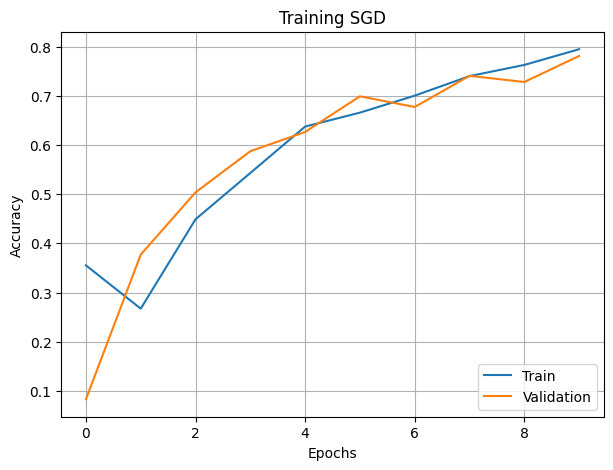

Test accuracy: 0.8579
Training Adam

Epoch: 1
Train accuracy: 0.1789
Val accuracy: 0.0912
Epoch: 2
Train accuracy: 0.2267
Val accuracy: 0.3017
Epoch: 3
Train accuracy: 0.3593
Val accuracy: 0.4342
Epoch: 4
Train accuracy: 0.4640
Val accuracy: 0.5350
Epoch: 5
Train accuracy: 0.5414
Val accuracy: 0.5663
Epoch: 6
Train accuracy: 0.6167
Val accuracy: 0.6554
Epoch: 7
Train accuracy: 0.6572
Val accuracy: 0.6571
Epoch: 8
Train accuracy: 0.7025
Val accuracy: 0.7296
Epoch: 9
Train accuracy: 0.7304
Val accuracy: 0.7196
Epoch: 10
Train accuracy: 0.7482
Val accuracy: 0.7442


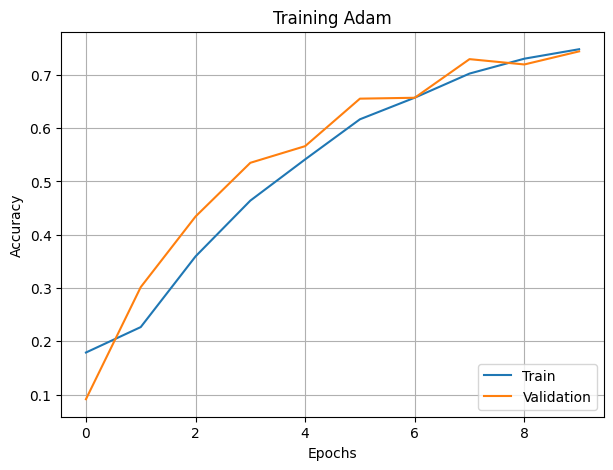

Test accuracy: 0.8488
Training AdamW

Epoch: 1
Train accuracy: 0.1949
Val accuracy: 0.1138
Epoch: 2
Train accuracy: 0.2993
Val accuracy: 0.3929
Epoch: 3
Train accuracy: 0.4418
Val accuracy: 0.4583
Epoch: 4
Train accuracy: 0.5471
Val accuracy: 0.5463
Epoch: 5
Train accuracy: 0.5919
Val accuracy: 0.5754
Epoch: 6
Train accuracy: 0.6361
Val accuracy: 0.6533
Epoch: 7
Train accuracy: 0.6919
Val accuracy: 0.7092
Epoch: 8
Train accuracy: 0.7060
Val accuracy: 0.6954
Epoch: 9
Train accuracy: 0.7326
Val accuracy: 0.7288
Epoch: 10
Train accuracy: 0.7579
Val accuracy: 0.7262


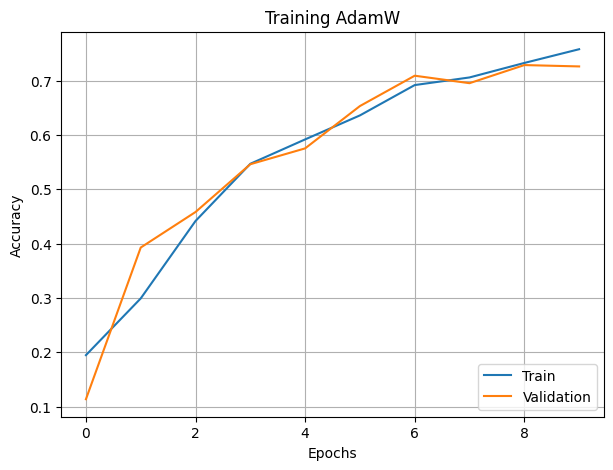

Test accuracy: 0.8542
Training RMSprop

Epoch: 1
Train accuracy: 0.1585
Val accuracy: 0.0546
Epoch: 2
Train accuracy: 0.0897
Val accuracy: 0.1454
Epoch: 3
Train accuracy: 0.1807
Val accuracy: 0.2329
Epoch: 4
Train accuracy: 0.2767
Val accuracy: 0.3446
Epoch: 5
Train accuracy: 0.3533
Val accuracy: 0.3904
Epoch: 6
Train accuracy: 0.4653
Val accuracy: 0.4537
Epoch: 7
Train accuracy: 0.5396
Val accuracy: 0.6012
Epoch: 8
Train accuracy: 0.6153
Val accuracy: 0.5650
Epoch: 9
Train accuracy: 0.6685
Val accuracy: 0.6333
Epoch: 10
Train accuracy: 0.7090
Val accuracy: 0.6421


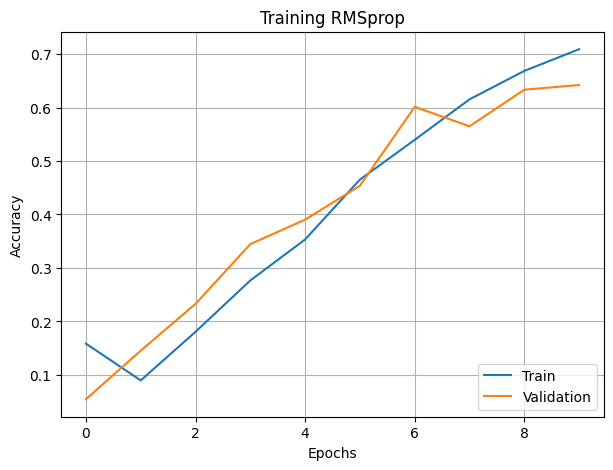

Test accuracy: 0.8450


In [ ]:
for optimizer_name in optimizers_names:
    model = ResNet(blocks_num_list).to(device)
    
    print(f"Training ResNet18 with {optimizer_name}\n")
    
    train_acc, val_acc = train(
        model,
        criterion,
        train_dataloaders[1],
        val_dataloader,
        optimizer=get_optimizer(optimizer_name, model),
        epochs=10
    )

    test_acc = test(model, test_dataloader)

    print(f"\nTest accuracy: {test_acc:.4f}")

    plot_history(train_acc, val_acc, optimizer_name)

In [23]:
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 0.1]

In [52]:
blocks_num_list = [2, 2, 2, 2]

Training ResNet18 with SGD
Batch size: 16
Learning rate: 1e-05



 10%|█         | 1/10 [00:43<06:32, 43.57s/it]

Epoch: [1/10]
Train accuracy: 0.0851
Val accuracy: 0.0579



 20%|██        | 2/10 [01:26<05:44, 43.01s/it]

Epoch: [2/10]
Train accuracy: 0.2096
Val accuracy: 0.3375



 30%|███       | 3/10 [02:09<05:01, 43.08s/it]

Epoch: [3/10]
Train accuracy: 0.3500
Val accuracy: 0.4450



 40%|████      | 4/10 [02:52<04:18, 43.11s/it]

Epoch: [4/10]
Train accuracy: 0.4504
Val accuracy: 0.5171



 50%|█████     | 5/10 [03:35<03:35, 43.09s/it]

Epoch: [5/10]
Train accuracy: 0.5212
Val accuracy: 0.5138



 60%|██████    | 6/10 [04:18<02:52, 43.10s/it]

Epoch: [6/10]
Train accuracy: 0.5875
Val accuracy: 0.6125



 70%|███████   | 7/10 [05:02<02:09, 43.19s/it]

Epoch: [7/10]
Train accuracy: 0.6239
Val accuracy: 0.6562



 80%|████████  | 8/10 [05:45<01:26, 43.33s/it]

Epoch: [8/10]
Train accuracy: 0.6604
Val accuracy: 0.6933



 90%|█████████ | 9/10 [06:29<00:43, 43.45s/it]

Epoch: [9/10]
Train accuracy: 0.6951
Val accuracy: 0.6987



100%|██████████| 10/10 [07:11<00:00, 43.19s/it]

Epoch: [10/10]
Train accuracy: 0.7157
Val accuracy: 0.6975



Test accuracy: 0.6921
Batch size: 16
Learning rate: 0.0001



 10%|█         | 1/10 [00:42<06:25, 42.80s/it]

Epoch: [1/10]
Train accuracy: 0.2828
Val accuracy: 0.0887



 20%|██        | 2/10 [01:25<05:42, 42.79s/it]

Epoch: [2/10]
Train accuracy: 0.4169
Val accuracy: 0.5092



 30%|███       | 3/10 [02:08<04:59, 42.85s/it]

Epoch: [3/10]
Train accuracy: 0.5651
Val accuracy: 0.6092



 40%|████      | 4/10 [02:51<04:16, 42.73s/it]

Epoch: [4/10]
Train accuracy: 0.6417
Val accuracy: 0.6271



 50%|█████     | 5/10 [03:33<03:33, 42.63s/it]

Epoch: [5/10]
Train accuracy: 0.6789
Val accuracy: 0.7046



 60%|██████    | 6/10 [04:15<02:50, 42.58s/it]

Epoch: [6/10]
Train accuracy: 0.7275
Val accuracy: 0.6787



 70%|███████   | 7/10 [04:58<02:07, 42.59s/it]

Epoch: [7/10]
Train accuracy: 0.7436
Val accuracy: 0.6646



 80%|████████  | 8/10 [05:40<01:25, 42.52s/it]

Epoch: [8/10]
Train accuracy: 0.7533
Val accuracy: 0.7504



 90%|█████████ | 9/10 [06:23<00:42, 42.51s/it]

Epoch: [9/10]
Train accuracy: 0.7807
Val accuracy: 0.7354



100%|██████████| 10/10 [07:06<00:00, 42.61s/it]

Epoch: [10/10]
Train accuracy: 0.8010
Val accuracy: 0.7771



Test accuracy: 0.7754
Batch size: 16
Learning rate: 0.001



 10%|█         | 1/10 [00:42<06:23, 42.58s/it]

Epoch: [1/10]
Train accuracy: 0.3818
Val accuracy: 0.1242



 20%|██        | 2/10 [01:24<05:39, 42.47s/it]

Epoch: [2/10]
Train accuracy: 0.4326
Val accuracy: 0.5171



 30%|███       | 3/10 [02:07<04:57, 42.45s/it]

Epoch: [3/10]
Train accuracy: 0.5911
Val accuracy: 0.6613



 40%|████      | 4/10 [02:49<04:14, 42.36s/it]

Epoch: [4/10]
Train accuracy: 0.6476
Val accuracy: 0.6892



 50%|█████     | 5/10 [03:32<03:32, 42.43s/it]

Epoch: [5/10]
Train accuracy: 0.6969
Val accuracy: 0.7342



 60%|██████    | 6/10 [04:14<02:50, 42.53s/it]

Epoch: [6/10]
Train accuracy: 0.7383
Val accuracy: 0.7267



 70%|███████   | 7/10 [04:57<02:07, 42.46s/it]

Epoch: [7/10]
Train accuracy: 0.7589
Val accuracy: 0.7800



 80%|████████  | 8/10 [05:39<01:24, 42.48s/it]

Epoch: [8/10]
Train accuracy: 0.7860
Val accuracy: 0.7917



 90%|█████████ | 9/10 [06:22<00:42, 42.53s/it]

Epoch: [9/10]
Train accuracy: 0.8043
Val accuracy: 0.7671



100%|██████████| 10/10 [07:04<00:00, 42.50s/it]

Epoch: [10/10]
Train accuracy: 0.8142
Val accuracy: 0.7963



Test accuracy: 0.7975
Batch size: 16
Learning rate: 0.01



 10%|█         | 1/10 [00:42<06:24, 42.76s/it]

Epoch: [1/10]
Train accuracy: 0.2487
Val accuracy: 0.0825



 20%|██        | 2/10 [01:25<05:41, 42.67s/it]

Epoch: [2/10]
Train accuracy: 0.3217
Val accuracy: 0.3704



 30%|███       | 3/10 [02:07<04:58, 42.64s/it]

Epoch: [3/10]
Train accuracy: 0.5067
Val accuracy: 0.5312



 40%|████      | 4/10 [02:50<04:15, 42.62s/it]

Epoch: [4/10]
Train accuracy: 0.5917
Val accuracy: 0.6075



 50%|█████     | 5/10 [03:32<03:32, 42.49s/it]

Epoch: [5/10]
Train accuracy: 0.6342
Val accuracy: 0.6792



 60%|██████    | 6/10 [04:15<02:49, 42.40s/it]

Epoch: [6/10]
Train accuracy: 0.6860
Val accuracy: 0.6983



 70%|███████   | 7/10 [04:57<02:07, 42.42s/it]

Epoch: [7/10]
Train accuracy: 0.7164
Val accuracy: 0.7354



 80%|████████  | 8/10 [05:39<01:24, 42.40s/it]

Epoch: [8/10]
Train accuracy: 0.7468
Val accuracy: 0.7750



 90%|█████████ | 9/10 [06:22<00:42, 42.36s/it]

Epoch: [9/10]
Train accuracy: 0.7668
Val accuracy: 0.7671



100%|██████████| 10/10 [07:04<00:00, 42.46s/it]

Epoch: [10/10]
Train accuracy: 0.7821
Val accuracy: 0.7692



Test accuracy: 0.7725
Batch size: 16
Learning rate: 0.1



 10%|█         | 1/10 [00:42<06:25, 42.80s/it]

Epoch: [1/10]
Train accuracy: 0.1424
Val accuracy: 0.0592



 20%|██        | 2/10 [01:25<05:40, 42.51s/it]

Epoch: [2/10]
Train accuracy: 0.1658
Val accuracy: 0.2150



 30%|███       | 3/10 [02:07<04:57, 42.51s/it]

Epoch: [3/10]
Train accuracy: 0.2771
Val accuracy: 0.2446



 40%|████      | 4/10 [02:50<04:15, 42.56s/it]

Epoch: [4/10]
Train accuracy: 0.3254
Val accuracy: 0.3854



 50%|█████     | 5/10 [03:32<03:32, 42.49s/it]

Epoch: [5/10]
Train accuracy: 0.3613
Val accuracy: 0.3588



 60%|██████    | 6/10 [04:15<02:49, 42.48s/it]

Epoch: [6/10]
Train accuracy: 0.4026
Val accuracy: 0.4646



 70%|███████   | 7/10 [04:57<02:07, 42.43s/it]

Epoch: [7/10]
Train accuracy: 0.4486
Val accuracy: 0.4829



 80%|████████  | 8/10 [05:39<01:24, 42.45s/it]

Epoch: [8/10]
Train accuracy: 0.4828
Val accuracy: 0.5563



 90%|█████████ | 9/10 [06:22<00:42, 42.43s/it]

Epoch: [9/10]
Train accuracy: 0.5392
Val accuracy: 0.5146



100%|██████████| 10/10 [07:04<00:00, 42.46s/it]

Epoch: [10/10]
Train accuracy: 0.5518
Val accuracy: 0.6029



Test accuracy: 0.6033
Batch size: 32
Learning rate: 1e-05



 10%|█         | 1/10 [00:41<06:09, 41.04s/it]

Epoch: [1/10]
Train accuracy: 0.0783
Val accuracy: 0.0517



 20%|██        | 2/10 [01:22<05:28, 41.08s/it]

Epoch: [2/10]
Train accuracy: 0.1486
Val accuracy: 0.2375



 30%|███       | 3/10 [02:03<04:47, 41.05s/it]

Epoch: [3/10]
Train accuracy: 0.2867
Val accuracy: 0.3258



 40%|████      | 4/10 [02:44<04:06, 41.05s/it]

Epoch: [4/10]
Train accuracy: 0.3617
Val accuracy: 0.4121



 50%|█████     | 5/10 [03:25<03:24, 40.96s/it]

Epoch: [5/10]
Train accuracy: 0.4289
Val accuracy: 0.4658



 60%|██████    | 6/10 [04:06<02:44, 41.05s/it]

Epoch: [6/10]
Train accuracy: 0.4944
Val accuracy: 0.5350



 70%|███████   | 7/10 [04:47<02:03, 41.04s/it]

Epoch: [7/10]
Train accuracy: 0.5300
Val accuracy: 0.5471



 80%|████████  | 8/10 [05:28<01:22, 41.01s/it]

Epoch: [8/10]
Train accuracy: 0.5708
Val accuracy: 0.5871



 90%|█████████ | 9/10 [06:09<00:40, 40.96s/it]

Epoch: [9/10]
Train accuracy: 0.6099
Val accuracy: 0.6046



100%|██████████| 10/10 [06:49<00:00, 40.99s/it]

Epoch: [10/10]
Train accuracy: 0.6285
Val accuracy: 0.6475



Test accuracy: 0.6583
Batch size: 32
Learning rate: 0.0001



 10%|█         | 1/10 [00:40<06:07, 40.87s/it]

Epoch: [1/10]
Train accuracy: 0.1969
Val accuracy: 0.0688



 20%|██        | 2/10 [01:21<05:27, 40.91s/it]

Epoch: [2/10]
Train accuracy: 0.3142
Val accuracy: 0.3937



 30%|███       | 3/10 [02:02<04:46, 40.86s/it]

Epoch: [3/10]
Train accuracy: 0.4851
Val accuracy: 0.5471



 40%|████      | 4/10 [02:43<04:05, 40.92s/it]

Epoch: [4/10]
Train accuracy: 0.5979
Val accuracy: 0.6500



 50%|█████     | 5/10 [03:24<03:24, 40.94s/it]

Epoch: [5/10]
Train accuracy: 0.6540
Val accuracy: 0.6508



 60%|██████    | 6/10 [04:05<02:43, 40.98s/it]

Epoch: [6/10]
Train accuracy: 0.6950
Val accuracy: 0.7108



 70%|███████   | 7/10 [04:46<02:02, 40.98s/it]

Epoch: [7/10]
Train accuracy: 0.7301
Val accuracy: 0.7375



 80%|████████  | 8/10 [05:27<01:22, 41.02s/it]

Epoch: [8/10]
Train accuracy: 0.7481
Val accuracy: 0.7421



 90%|█████████ | 9/10 [06:08<00:40, 40.93s/it]

Epoch: [9/10]
Train accuracy: 0.7683
Val accuracy: 0.7846



100%|██████████| 10/10 [06:49<00:00, 40.95s/it]

Epoch: [10/10]
Train accuracy: 0.7843
Val accuracy: 0.7567



Test accuracy: 0.7688
Batch size: 32
Learning rate: 0.001



 10%|█         | 1/10 [00:41<06:09, 41.06s/it]

Epoch: [1/10]
Train accuracy: 0.3987
Val accuracy: 0.0800



 20%|██        | 2/10 [01:22<05:28, 41.04s/it]

Epoch: [2/10]
Train accuracy: 0.4125
Val accuracy: 0.5842



 30%|███       | 3/10 [02:03<04:47, 41.03s/it]

Epoch: [3/10]
Train accuracy: 0.5664
Val accuracy: 0.6317



 40%|████      | 4/10 [02:44<04:06, 41.04s/it]

Epoch: [4/10]
Train accuracy: 0.6546
Val accuracy: 0.6433



 50%|█████     | 5/10 [03:25<03:25, 41.03s/it]

Epoch: [5/10]
Train accuracy: 0.6944
Val accuracy: 0.7346



 60%|██████    | 6/10 [04:06<02:43, 40.99s/it]

Epoch: [6/10]
Train accuracy: 0.7269
Val accuracy: 0.7150



 70%|███████   | 7/10 [04:47<02:02, 40.97s/it]

Epoch: [7/10]
Train accuracy: 0.7547
Val accuracy: 0.7342



 80%|████████  | 8/10 [05:27<01:21, 40.95s/it]

Epoch: [8/10]
Train accuracy: 0.7736
Val accuracy: 0.7417



 90%|█████████ | 9/10 [06:08<00:40, 40.94s/it]

Epoch: [9/10]
Train accuracy: 0.7785
Val accuracy: 0.7729



100%|██████████| 10/10 [06:49<00:00, 40.98s/it]

Epoch: [10/10]
Train accuracy: 0.8046
Val accuracy: 0.7642



Test accuracy: 0.7717
Batch size: 32
Learning rate: 0.01



 10%|█         | 1/10 [00:41<06:10, 41.12s/it]

Epoch: [1/10]
Train accuracy: 0.3071
Val accuracy: 0.0833



 20%|██        | 2/10 [01:21<05:27, 40.95s/it]

Epoch: [2/10]
Train accuracy: 0.2474
Val accuracy: 0.3804



 30%|███       | 3/10 [02:02<04:46, 40.95s/it]

Epoch: [3/10]
Train accuracy: 0.4304
Val accuracy: 0.4583



 40%|████      | 4/10 [02:43<04:05, 40.99s/it]

Epoch: [4/10]
Train accuracy: 0.5461
Val accuracy: 0.5129



 50%|█████     | 5/10 [03:25<03:25, 41.04s/it]

Epoch: [5/10]
Train accuracy: 0.6172
Val accuracy: 0.6242



 60%|██████    | 6/10 [04:05<02:43, 40.99s/it]

Epoch: [6/10]
Train accuracy: 0.6589
Val accuracy: 0.6763



 70%|███████   | 7/10 [04:47<02:03, 41.00s/it]

Epoch: [7/10]
Train accuracy: 0.7024
Val accuracy: 0.6942



 80%|████████  | 8/10 [05:27<01:21, 40.99s/it]

Epoch: [8/10]
Train accuracy: 0.7365
Val accuracy: 0.7254



 90%|█████████ | 9/10 [06:09<00:41, 41.06s/it]

Epoch: [9/10]
Train accuracy: 0.7417
Val accuracy: 0.7667



100%|██████████| 10/10 [06:50<00:00, 41.02s/it]

Epoch: [10/10]
Train accuracy: 0.7686
Val accuracy: 0.7633



Test accuracy: 0.7408
Batch size: 32
Learning rate: 0.1



 10%|█         | 1/10 [00:41<06:09, 41.05s/it]

Epoch: [1/10]
Train accuracy: 0.1017
Val accuracy: 0.0437



 20%|██        | 2/10 [01:22<05:30, 41.37s/it]

Epoch: [2/10]
Train accuracy: 0.1285
Val accuracy: 0.1883



 30%|███       | 3/10 [02:04<04:49, 41.40s/it]

Epoch: [3/10]
Train accuracy: 0.2210
Val accuracy: 0.2596



 40%|████      | 4/10 [02:45<04:07, 41.30s/it]

Epoch: [4/10]
Train accuracy: 0.2985
Val accuracy: 0.3542



 50%|█████     | 5/10 [03:26<03:26, 41.22s/it]

Epoch: [5/10]
Train accuracy: 0.3837
Val accuracy: 0.4179



 60%|██████    | 6/10 [04:07<02:44, 41.16s/it]

Epoch: [6/10]
Train accuracy: 0.4535
Val accuracy: 0.3871



 70%|███████   | 7/10 [04:48<02:03, 41.06s/it]

Epoch: [7/10]
Train accuracy: 0.5060
Val accuracy: 0.5117



 80%|████████  | 8/10 [05:29<01:22, 41.01s/it]

Epoch: [8/10]
Train accuracy: 0.5682
Val accuracy: 0.5679



 90%|█████████ | 9/10 [06:09<00:40, 40.96s/it]

Epoch: [9/10]
Train accuracy: 0.5985
Val accuracy: 0.6471



100%|██████████| 10/10 [06:50<00:00, 41.10s/it]

Epoch: [10/10]
Train accuracy: 0.6272
Val accuracy: 0.6242



Test accuracy: 0.5992
Batch size: 64
Learning rate: 1e-05



 10%|█         | 1/10 [00:40<06:04, 40.45s/it]

Epoch: [1/10]
Train accuracy: 0.0510
Val accuracy: 0.0529



 20%|██        | 2/10 [01:20<05:22, 40.33s/it]

Epoch: [2/10]
Train accuracy: 0.0871
Val accuracy: 0.1475



 30%|███       | 3/10 [02:01<04:42, 40.32s/it]

Epoch: [3/10]
Train accuracy: 0.1850
Val accuracy: 0.1954



 40%|████      | 4/10 [02:41<04:01, 40.33s/it]

Epoch: [4/10]
Train accuracy: 0.2317
Val accuracy: 0.2404



 50%|█████     | 5/10 [03:21<03:21, 40.27s/it]

Epoch: [5/10]
Train accuracy: 0.2640
Val accuracy: 0.2946



 60%|██████    | 6/10 [04:01<02:41, 40.32s/it]

Epoch: [6/10]
Train accuracy: 0.3171
Val accuracy: 0.3525



 70%|███████   | 7/10 [04:42<02:00, 40.31s/it]

Epoch: [7/10]
Train accuracy: 0.3640
Val accuracy: 0.3979



 80%|████████  | 8/10 [05:22<01:20, 40.30s/it]

Epoch: [8/10]
Train accuracy: 0.4136
Val accuracy: 0.4142



 90%|█████████ | 9/10 [06:02<00:40, 40.35s/it]

Epoch: [9/10]
Train accuracy: 0.4496
Val accuracy: 0.4825



100%|██████████| 10/10 [06:43<00:00, 40.31s/it]

Epoch: [10/10]
Train accuracy: 0.4735
Val accuracy: 0.4804



Test accuracy: 0.4800
Batch size: 64
Learning rate: 0.0001



 10%|█         | 1/10 [00:40<06:04, 40.46s/it]

Epoch: [1/10]
Train accuracy: 0.1431
Val accuracy: 0.0525



 20%|██        | 2/10 [01:20<05:23, 40.45s/it]

Epoch: [2/10]
Train accuracy: 0.2226
Val accuracy: 0.2946



 30%|███       | 3/10 [02:01<04:42, 40.34s/it]

Epoch: [3/10]
Train accuracy: 0.4051
Val accuracy: 0.4813



 40%|████      | 4/10 [02:41<04:02, 40.38s/it]

Epoch: [4/10]
Train accuracy: 0.5260
Val accuracy: 0.5787



 50%|█████     | 5/10 [03:22<03:22, 40.42s/it]

Epoch: [5/10]
Train accuracy: 0.5867
Val accuracy: 0.6008



 60%|██████    | 6/10 [04:02<02:41, 40.38s/it]

Epoch: [6/10]
Train accuracy: 0.6481
Val accuracy: 0.6708



 70%|███████   | 7/10 [04:42<02:00, 40.30s/it]

Epoch: [7/10]
Train accuracy: 0.6842
Val accuracy: 0.7137



 80%|████████  | 8/10 [05:22<01:20, 40.29s/it]

Epoch: [8/10]
Train accuracy: 0.7118
Val accuracy: 0.6438



 90%|█████████ | 9/10 [06:03<00:40, 40.30s/it]

Epoch: [9/10]
Train accuracy: 0.7215
Val accuracy: 0.7100



100%|██████████| 10/10 [06:43<00:00, 40.35s/it]

Epoch: [10/10]
Train accuracy: 0.7629
Val accuracy: 0.7400



Test accuracy: 0.7567
Batch size: 64
Learning rate: 0.001



 10%|█         | 1/10 [00:40<06:02, 40.23s/it]

Epoch: [1/10]
Train accuracy: 0.3347
Val accuracy: 0.0533



 20%|██        | 2/10 [01:20<05:21, 40.20s/it]

Epoch: [2/10]
Train accuracy: 0.3068
Val accuracy: 0.4358



 30%|███       | 3/10 [02:00<04:41, 40.19s/it]

Epoch: [3/10]
Train accuracy: 0.4693
Val accuracy: 0.5517



 40%|████      | 4/10 [02:40<04:01, 40.24s/it]

Epoch: [4/10]
Train accuracy: 0.5563
Val accuracy: 0.6096



 50%|█████     | 5/10 [03:21<03:21, 40.26s/it]

Epoch: [5/10]
Train accuracy: 0.6138
Val accuracy: 0.6479



 60%|██████    | 6/10 [04:01<02:40, 40.23s/it]

Epoch: [6/10]
Train accuracy: 0.6646
Val accuracy: 0.6879



 70%|███████   | 7/10 [04:41<02:00, 40.25s/it]

Epoch: [7/10]
Train accuracy: 0.6996
Val accuracy: 0.7125



 80%|████████  | 8/10 [05:22<01:20, 40.30s/it]

Epoch: [8/10]
Train accuracy: 0.7361
Val accuracy: 0.6937



 90%|█████████ | 9/10 [06:02<00:40, 40.34s/it]

Epoch: [9/10]
Train accuracy: 0.7362
Val accuracy: 0.7417



100%|██████████| 10/10 [06:43<00:00, 40.31s/it]

Epoch: [10/10]
Train accuracy: 0.7758
Val accuracy: 0.6950



Test accuracy: 0.7079
Batch size: 64
Learning rate: 0.01



 10%|█         | 1/10 [00:40<06:04, 40.48s/it]

Epoch: [1/10]
Train accuracy: 0.3806
Val accuracy: 0.0929



 20%|██        | 2/10 [01:20<05:23, 40.44s/it]

Epoch: [2/10]
Train accuracy: 0.2053
Val accuracy: 0.2621



 30%|███       | 3/10 [02:01<04:42, 40.42s/it]

Epoch: [3/10]
Train accuracy: 0.3762
Val accuracy: 0.4167



 40%|████      | 4/10 [02:41<04:02, 40.44s/it]

Epoch: [4/10]
Train accuracy: 0.4904
Val accuracy: 0.5238



 50%|█████     | 5/10 [03:22<03:22, 40.46s/it]

Epoch: [5/10]
Train accuracy: 0.5428
Val accuracy: 0.5725



 60%|██████    | 6/10 [04:02<02:41, 40.43s/it]

Epoch: [6/10]
Train accuracy: 0.6128
Val accuracy: 0.6625



 70%|███████   | 7/10 [04:43<02:01, 40.48s/it]

Epoch: [7/10]
Train accuracy: 0.6786
Val accuracy: 0.6983



 80%|████████  | 8/10 [05:23<01:21, 40.52s/it]

Epoch: [8/10]
Train accuracy: 0.6964
Val accuracy: 0.7000



 90%|█████████ | 9/10 [06:04<00:40, 40.54s/it]

Epoch: [9/10]
Train accuracy: 0.7304
Val accuracy: 0.7233



100%|██████████| 10/10 [06:44<00:00, 40.46s/it]

Epoch: [10/10]
Train accuracy: 0.7557
Val accuracy: 0.7308



Test accuracy: 0.7371
Batch size: 64
Learning rate: 0.1



 10%|█         | 1/10 [00:40<06:05, 40.57s/it]

Epoch: [1/10]
Train accuracy: 0.1943
Val accuracy: 0.0950



 20%|██        | 2/10 [01:21<05:24, 40.50s/it]

Epoch: [2/10]
Train accuracy: 0.1904
Val accuracy: 0.2875



 30%|███       | 3/10 [02:01<04:43, 40.55s/it]

Epoch: [3/10]
Train accuracy: 0.3158
Val accuracy: 0.3513



 40%|████      | 4/10 [02:42<04:04, 40.71s/it]

Epoch: [4/10]
Train accuracy: 0.4297
Val accuracy: 0.4988



 50%|█████     | 5/10 [03:23<03:24, 40.85s/it]

Epoch: [5/10]
Train accuracy: 0.5168
Val accuracy: 0.5667



 60%|██████    | 6/10 [04:04<02:43, 40.98s/it]

Epoch: [6/10]
Train accuracy: 0.5703
Val accuracy: 0.5721



 70%|███████   | 7/10 [04:45<02:02, 41.00s/it]

Epoch: [7/10]
Train accuracy: 0.6272
Val accuracy: 0.6196



 80%|████████  | 8/10 [05:27<01:22, 41.02s/it]

Epoch: [8/10]
Train accuracy: 0.6540
Val accuracy: 0.6687



 90%|█████████ | 9/10 [23:17<06:02, 362.74s/it]

Epoch: [9/10]
Train accuracy: 0.6842
Val accuracy: 0.6937



100%|██████████| 10/10 [23:57<00:00, 143.77s/it]

Epoch: [10/10]
Train accuracy: 0.6982
Val accuracy: 0.6771



Test accuracy: 0.6867


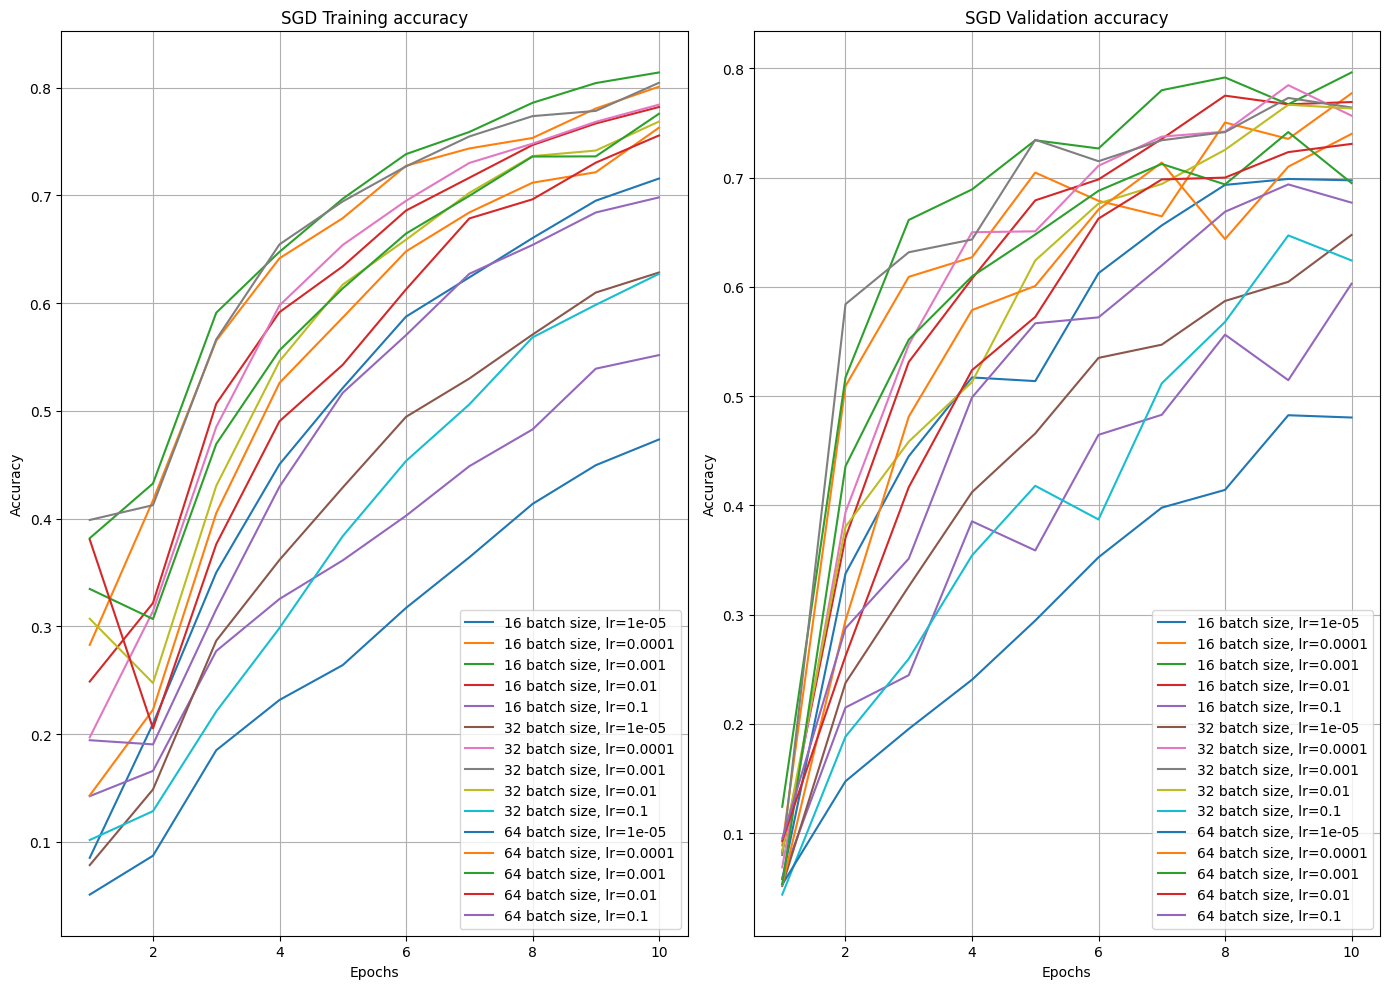

In [59]:
print("Training ResNet18 with SGD")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

for train_dataloader in train_dataloaders:
    for lr in learning_rates:
        model = ResNet(blocks_num_list).to(device)

        print(
            f"Batch size: {train_dataloader.batch_size}\n"
            f"Learning rate: {lr}\n"
        )

        train_acc, val_acc = train(
            model,
            criterion,
            train_dataloader,
            val_dataloader,
            optimizer=get_optimizer("SGD", model, lr=lr),
            epochs=10,
        )

        label=f'{train_dataloader.batch_size} batch size, lr={lr}'

        ax1.plot(np.arange(1, 11), train_acc, label=label)
        ax2.plot(np.arange(1, 11), val_acc, label=label)

        test_acc = test(model, test_dataloader)

        print(f"Test accuracy: {test_acc:.4f}\n")

for ax in (ax1, ax2):
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.grid(True)

ax1.set_title("SGD Training accuracy")
ax2.set_title("SGD Validation accuracy")

plt.tight_layout()
plt.show()